In [7]:
import pandas as pd
from scipy.signal import correlate
import numpy as np
import sys
sys.path.append(r'C:\Users\clima\Desktop\Aptamers\src')
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from dna import DNA_ENERGIES
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [8]:

BpEnergy = DNA_ENERGIES.TRI_TETRA_LOOPS
subsequence= list(BpEnergy.keys())

def find_consecutive_dots(string):
    dot_locations = []  # List to store locations of consecutive dots
    consecutive_dots = []  # List to store consecutive dot sequences

    for i, char in enumerate(string):
        if char == '.':
            dot_locations.append(i)
        else:
            if len(dot_locations) > 0:
                consecutive_dots.append(dot_locations)
            dot_locations = []

    return consecutive_dots


def bag_of_sequences(subsequence, sequence, consecutive_dots):
    desc = np.zeros(len(subsequence), dtype = int)
    for count, sub in enumerate(subsequence):
        for m in consecutive_dots:
                lis =  ''.join([sequence[n] for n in m])
                if sub in lis:
                    desc[count]+=1
    return desc
                    
def descriptors(sequence, structure):
    consecutive_dots = find_consecutive_dots(structure)
    return bag_of_sequences(subsequence, sequence, consecutive_dots)

In [4]:
df = pd.read_csv(r'C:\Users\clima\Desktop\Aptamers\data\preprocessed _files\UNAfold_merged_all.csv')
print('Numeber sequences after merge:',len(df))
df = df.drop_duplicates(subset='Sequence')
print('Numeber of unique sequences after preprocessing:',len(df))

percentile_95 = np.percentile(df['Sequence'].apply(len), 95) 
percentile_5 = np.percentile(df['Sequence'].apply(len), 5)

df = df[df['Sequence'].apply(len).between(np.floor(percentile_5) +1, np.ceil(percentile_95))]
df = df.reset_index()

Numeber sequences after merge: 4933
Numeber of unique sequences after preprocessing: 4933


In [5]:
X_raw= np.zeros((len(df), len(subsequence)), dtype=int)
for count, (seq, str) in enumerate(zip(df['Sequence'], df['Structure_UNA'])):
    X_raw[count, :] =  descriptors(seq, str)
    
selector = VarianceThreshold(0)
X = selector.fit_transform(X_raw) 

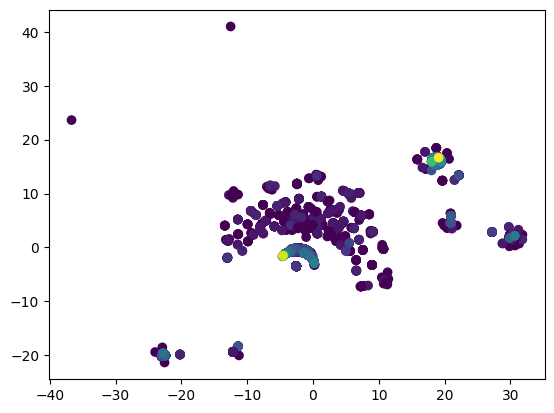

In [6]:

    
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=150).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

In [9]:

n_components = 10
n_top_words = 5
init = "nndsvda"
nmf= NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(X)

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

c:\Users\clima\anaconda3b\envs\aptamers_fold\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


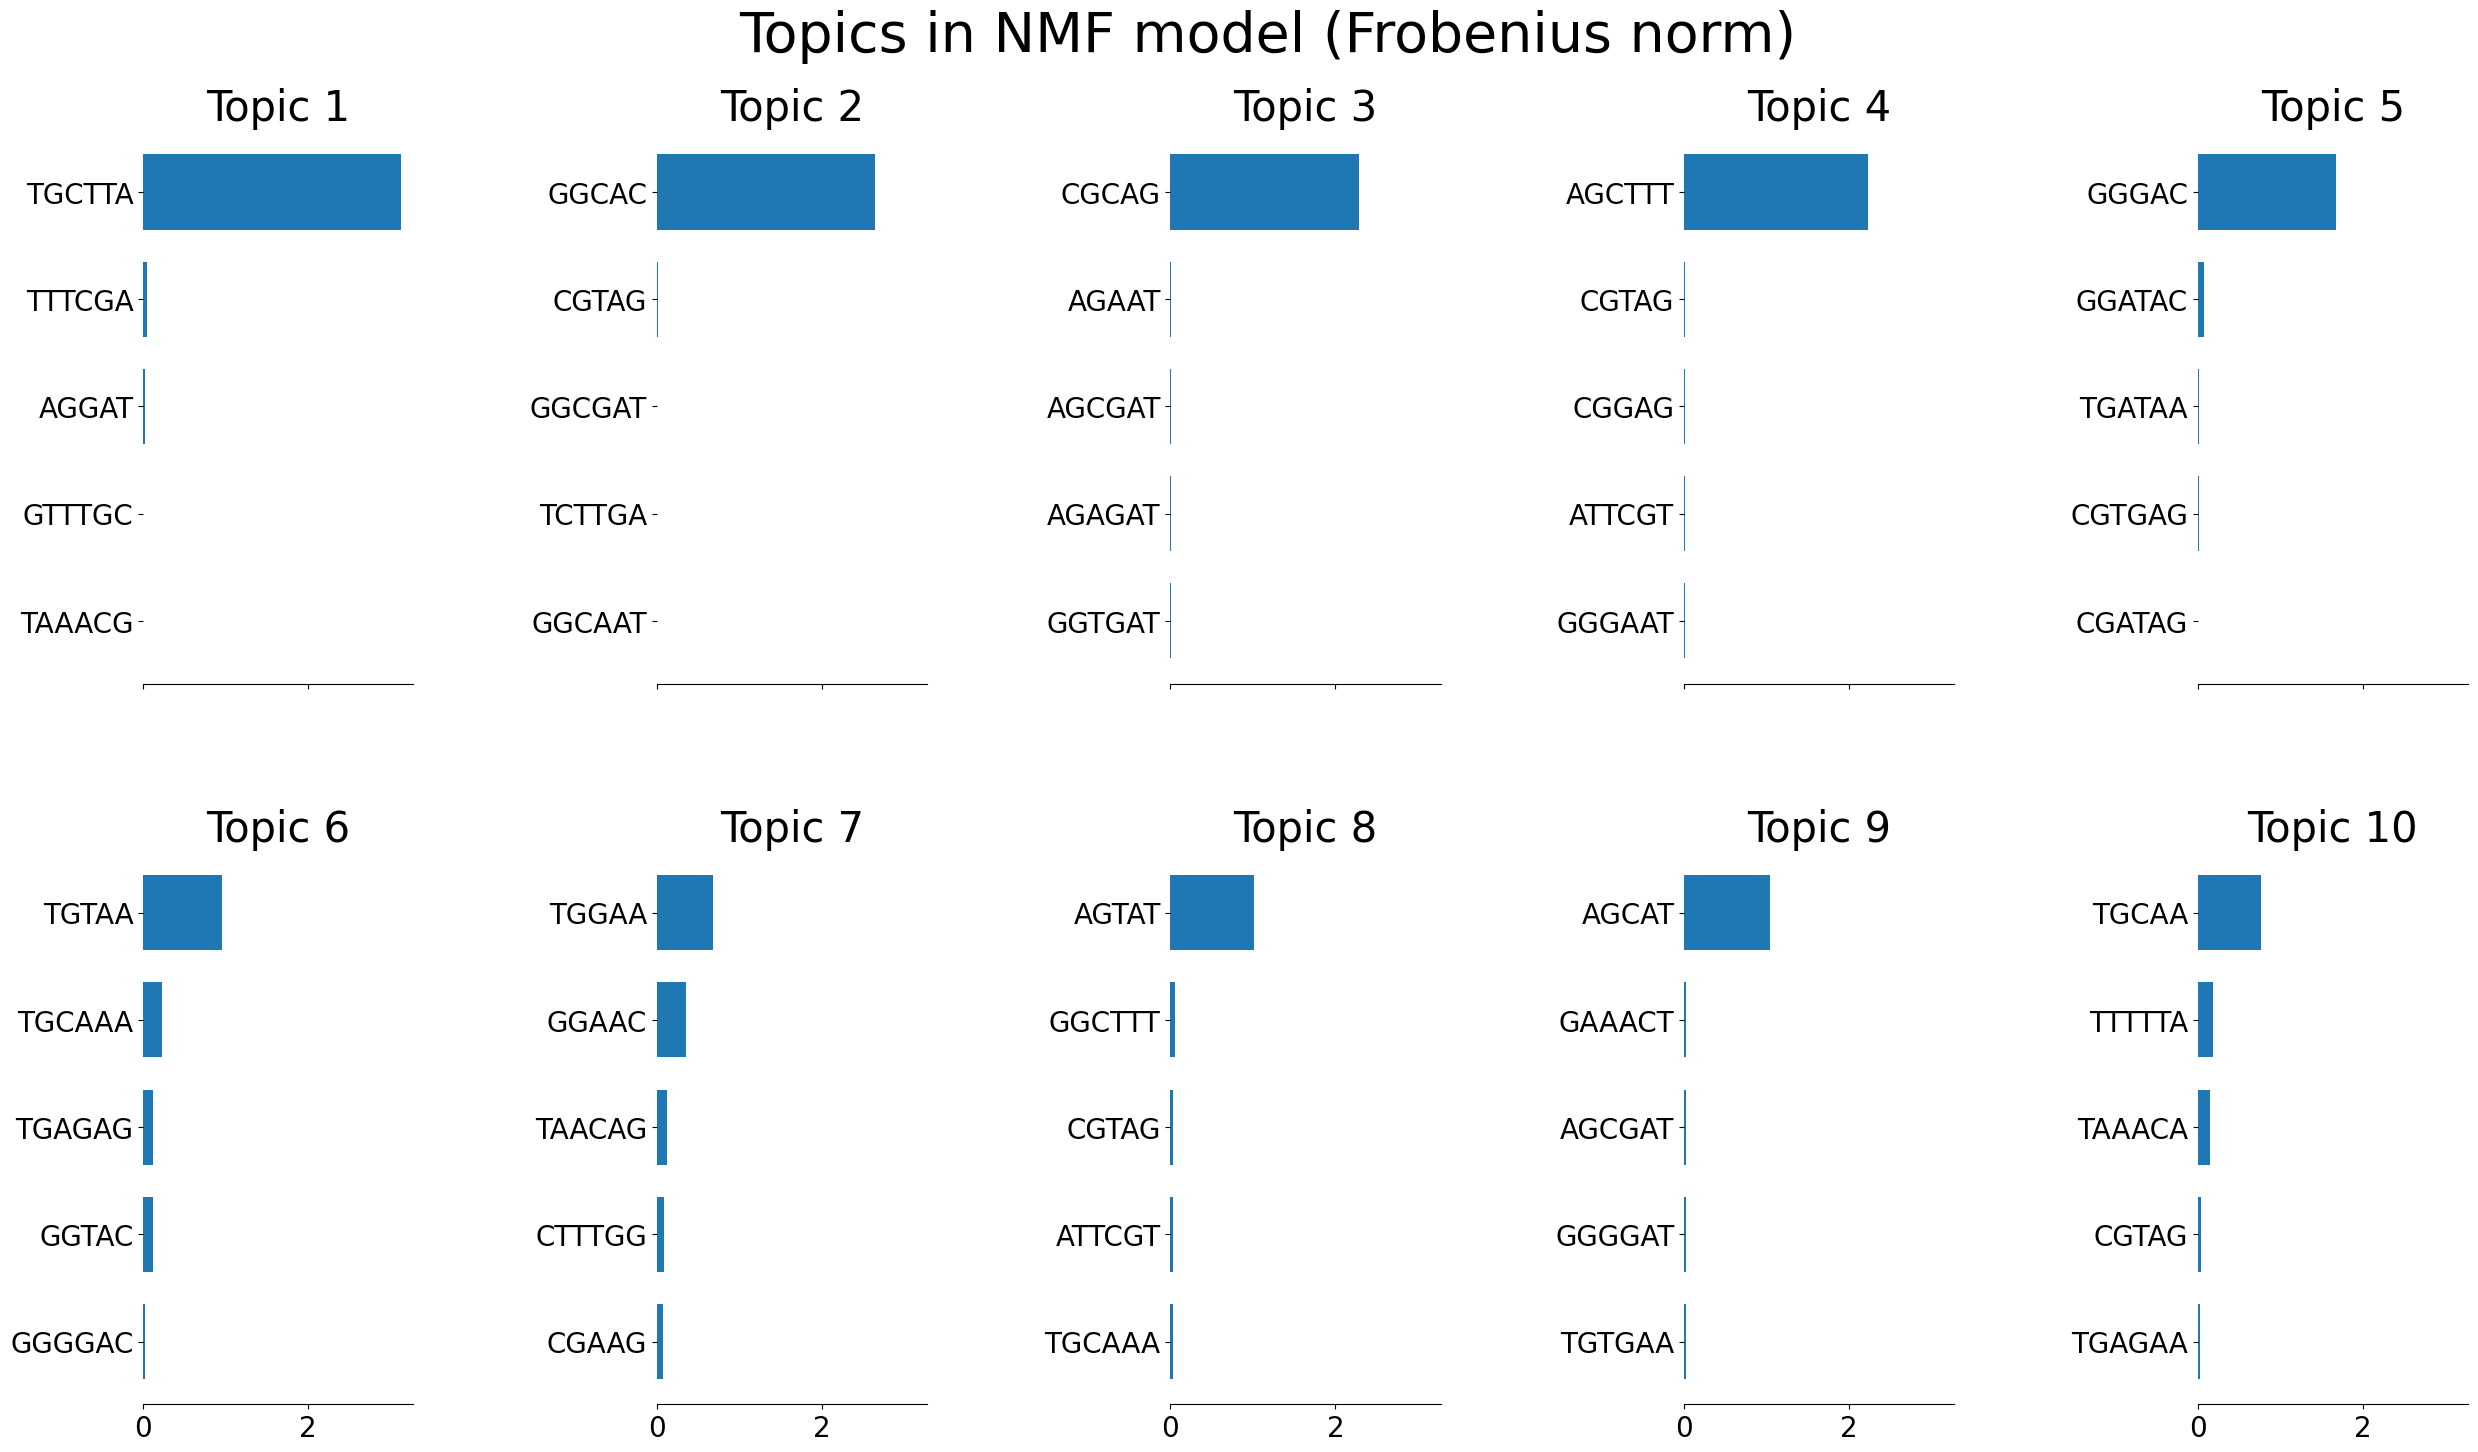

c:\Users\clima\anaconda3b\envs\aptamers_fold\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


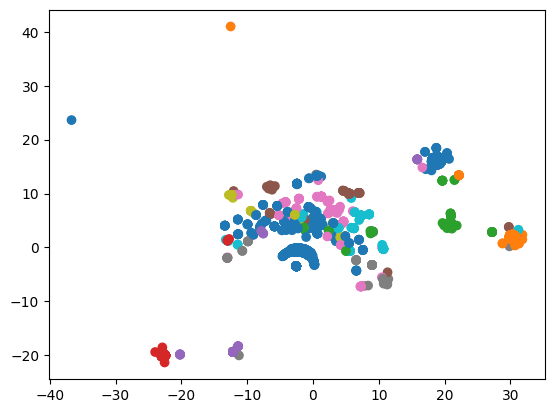

In [10]:
plot_top_words(
    nmf, np.asarray(subsequence), n_top_words, "Topics in NMF model (Frobenius norm)"
)
dc_tp = []
W = nmf.fit_transform(X)
for doc_idx, topic_dist in enumerate(W):
    dc_tp.append(topic_dist.argmax())
colors = dc_tp#np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='tab10')

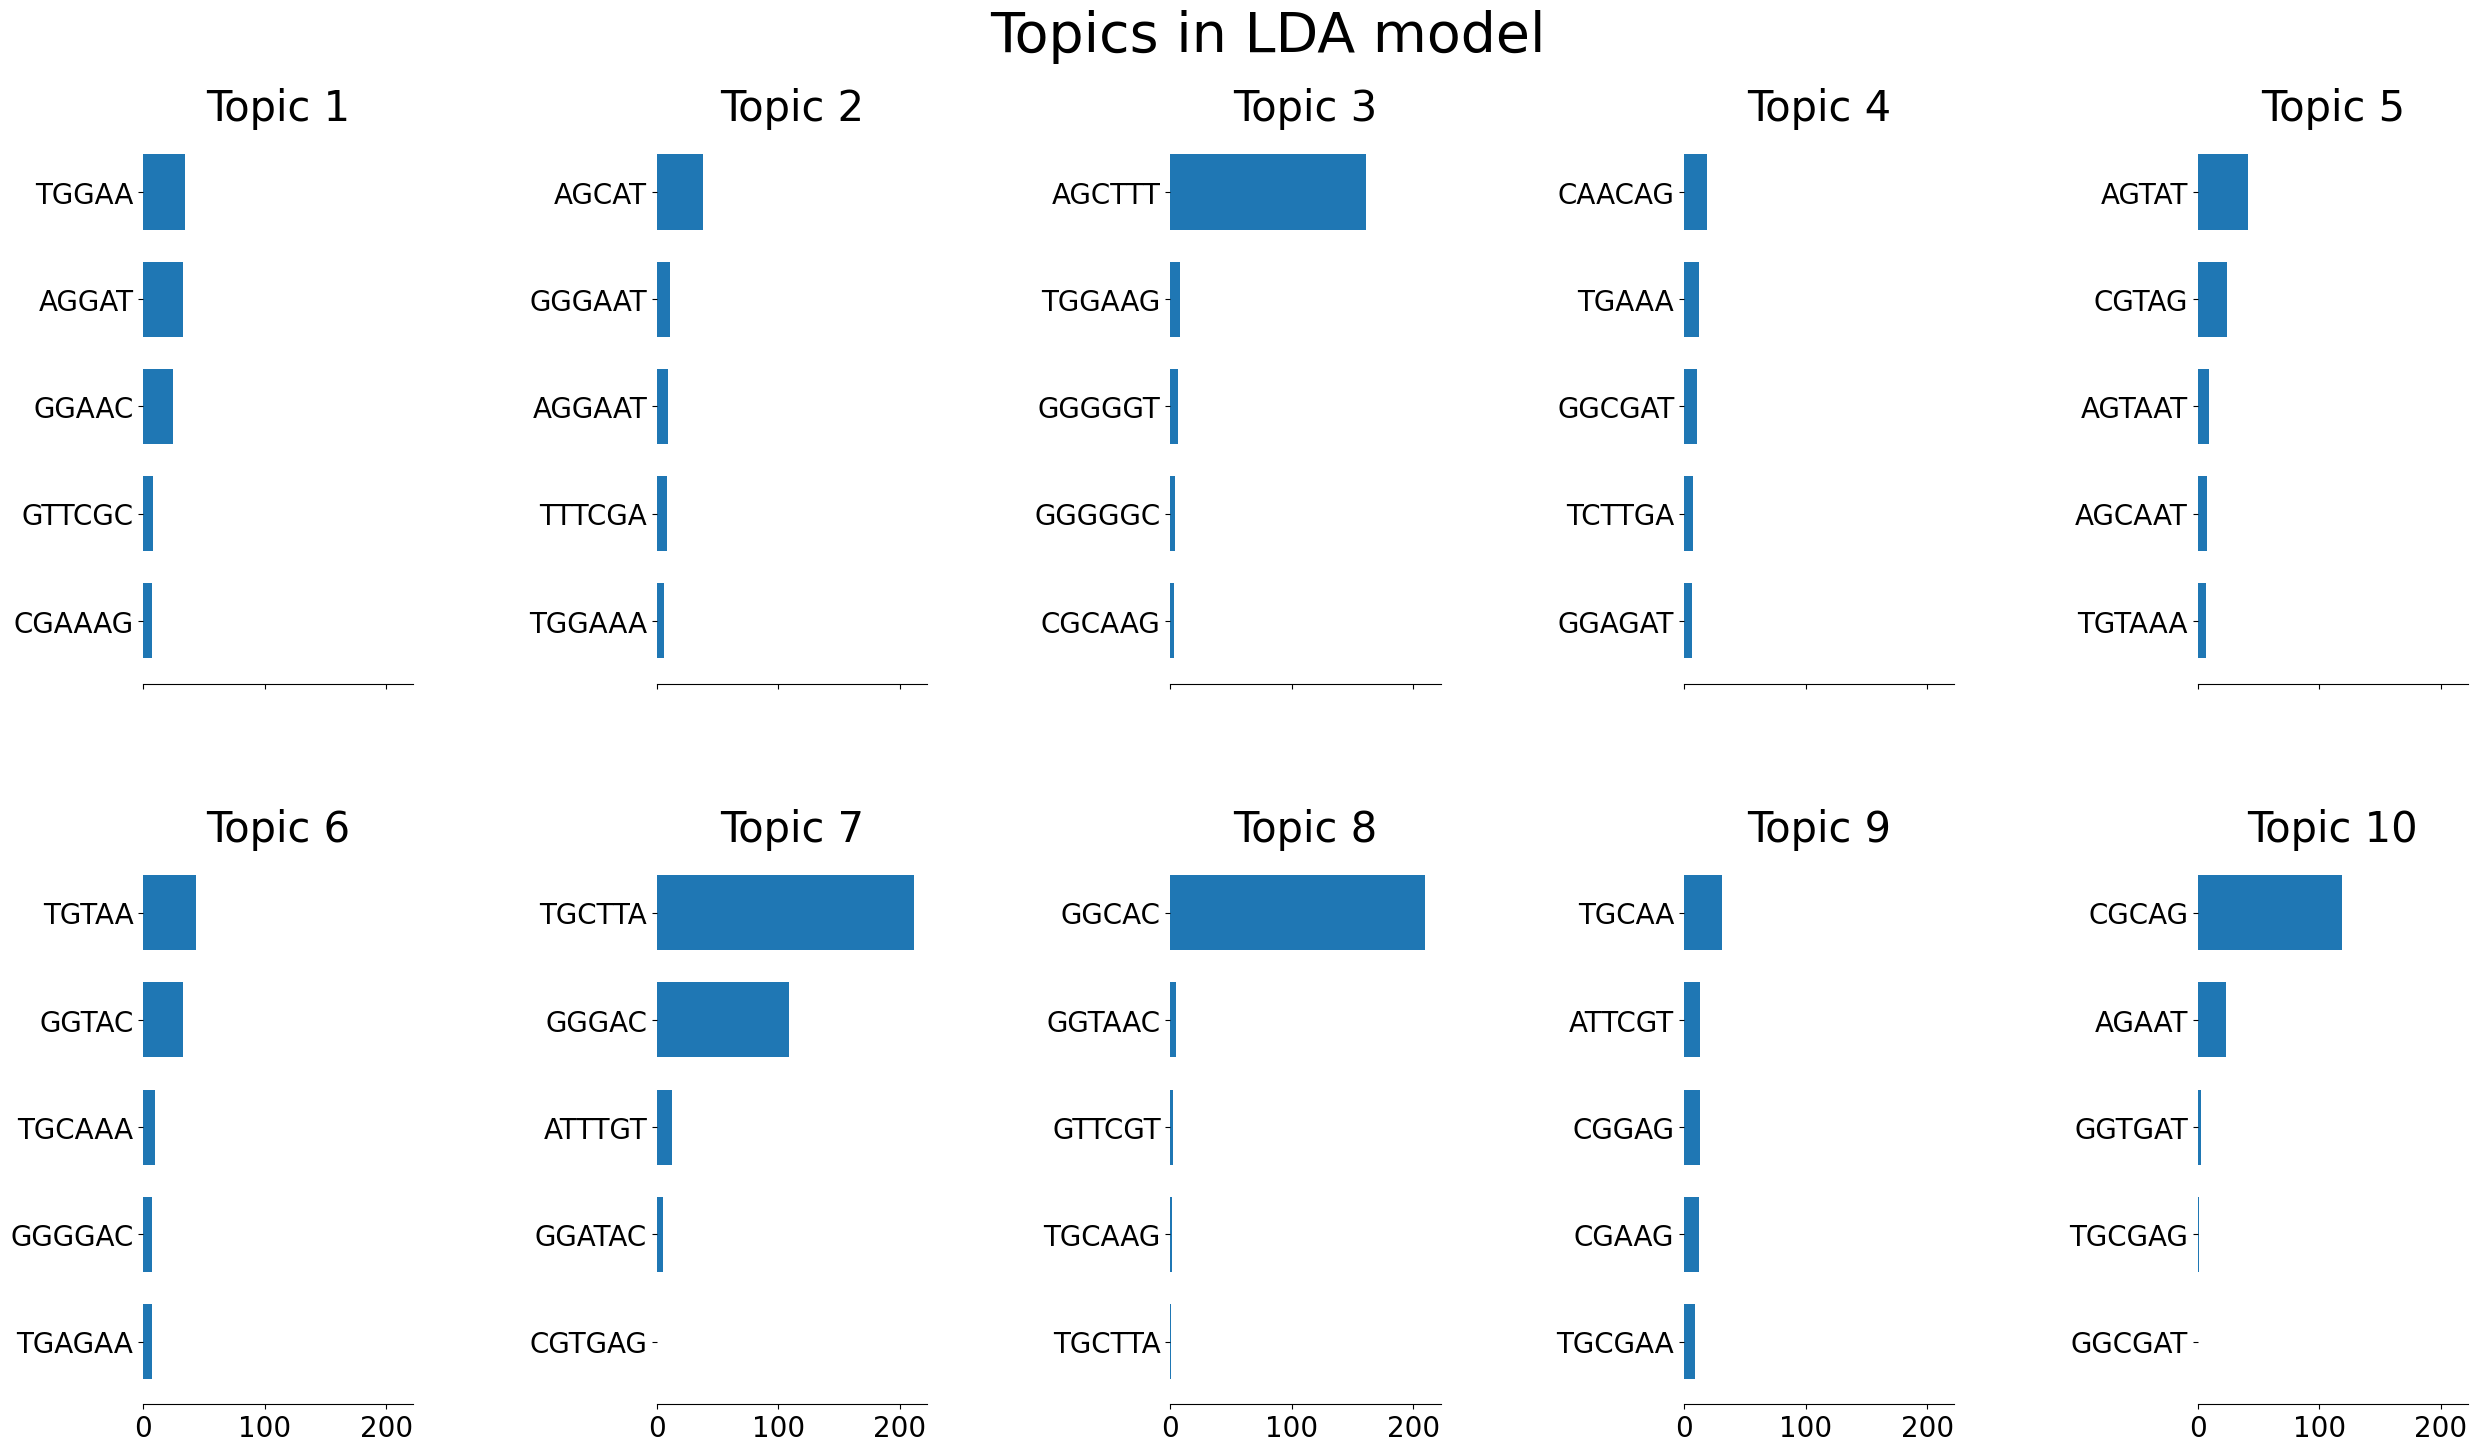

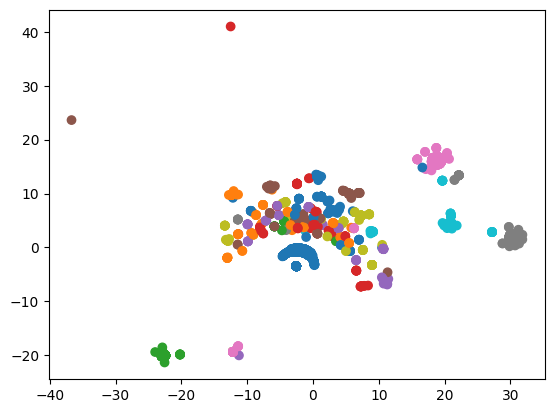

In [11]:
n_components = 10
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(X)
plot_top_words(lda, np.asarray(subsequence), n_top_words, "Topics in LDA model")
W =lda.transform(X)
dc_tp = []
for doc_idx, topic_dist in enumerate(W):
    dc_tp.append(topic_dist.argmax())

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=150).fit_transform(X)
X_embedded = X_embedded
colors = dc_tp #np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='tab10' )
